# MA999 - Agent based modelling 3 - Congestion games

## MathSys CDT 2023

### Lecturer: Paolo Turrini 
(thanks to Colm Connaughton and Stas Zhydkov)

## Example 2: Traffic flow patterns

* Suppose we have $N = 100$ drivers who commute every day from point 0 to point 3 on a simple road network:
<img src="images/network1.png" alt="Drawing" style="width: 500px;"/>
* There are multiple paths in the network leading from 0 to 3.
* The travel time for each link, $i$, depends on the number of drivers, $x_i$, travelling on that link: generally travel time increases as the usage goes up.
* Build a model to estimate the average travel time from 0 to 3.

### Wardrop equilibrium and congestion games

We can think of this problem as a repeated multiplayer game in which each player (agent) tries to choose the route that minimises its travel time subject to the choices of all the other agents.

[John Wardrop](https://en.wikipedia.org/wiki/John_Glen_Wardrop) (a Warwick local!) suggested in 1952 that the observed pattern of use should satisfy the following principle: 

> journey times in all routes actually used are equal and less than those that would be experienced by a single vehicle on any unused route.

This is nowadays known as Wardrop equilibrium.

### Wardrop equilibrium and congestion games

It is an analogue of a Nash equilibrium: no driver can improve their journey time by unilaterally switching to a different route.

Can we build an ABM to demonstrate the existence of Wardrop equilibrium from simple and plausible behavioural rules?

### ABM model of commuter patterns
We shall assume that the travel time, $\tau_i$, for each link, $i$, is a linear function of the number of agents $x_i$ travelling on that link on a given day:
$$ \tau_i(x_i) = a_i\ x_i + b_i $$
with the parameters $a_i$ and $b_i$ varying from link to link. These are called **demand-delay functions**.

### Model description:
* Each agent has a prefered route.
* At each step (1 day) each agent travels its prefered route.
* Travel times for all routes are calculated based on the choices of the agents.
* Each agent compares travel time, $\tau_\text{c}$, of its current prefered route to the travel time of a randomly chosen alternative route, $\tau_\text{a}$, and calculates $\Delta \tau = \tau_\text{a} - \tau_\text{c}$. 
* If $\Delta \tau <0$, the agent updates its prefered route with probability
$$P = 1 - \exp(\Delta \tau/T),$$
before the next iteration where $T$ is a model parameter.

In [ ]:
%pwd

In [ ]:
%cd .

In [ ]:
import mesa
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random

import sys
sys.path.append('./code')
import importlib
import CG
importlib.reload(CG)

### Implementation of the model

First we need to define the graph:

In [7]:
# Make a graph
G = nx.DiGraph()
G.add_edges_from([(0, 1), (0, 2), (1, 3), (2, 3)])

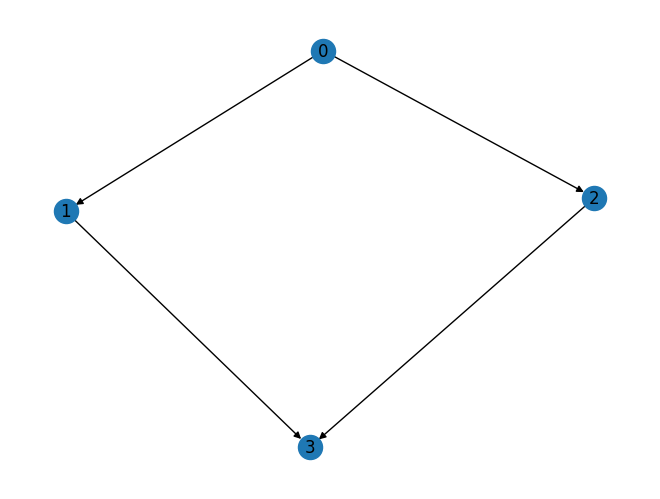

In [34]:
nx.draw(G, with_labels = True)

Next we make a list the available paths from 0 to 3

In [9]:
paths = list(nx.all_simple_paths(G, source=0, target=3))

In [10]:
for i, path in enumerate(paths):
    print(f"{i+1} : {[node for node in path]}")

1 : [0, 1, 3]
2 : [0, 2, 3]


We use a dictionary to store the parameters $(a_i, b_i)$ for each link:

In [11]:
# define link parameters according to sorted edges
print(sorted(list(G.edges())))
link_parameters = [(0.1, 0.0), # 0->1
                   (0.0, 15.0), # 0->2
                   (0.0, 15.0), # 1->3
                   (0.1, 0.0)] # 2->3

[(0, 1), (0, 2), (1, 3), (2, 3)]


Since paths can share links, it will be helpful to define a link-path adjacency matrix:

$$A_{i j} = \left\{\begin{array}{ll}1& \text{if link $i$ is part of path $j$}\\
          0 & \text{otherwise}\end{array}\right.$$

In [12]:
def link_path_adjacency(link, path):
    """Check if a given link (u, v) is on a given path."""
    for i in range(len(path) - 1):
        if (link[0] == path[i] and link[1] == path[i+1]):
            return 1
    return 0

edges = sorted(list(G.edges()))
A = np.zeros((len(edges), len(paths)), dtype=int)
for i, edge in enumerate(edges):
    for j, path in enumerate(paths):
        A[i, j] = link_path_adjacency(edge, path)

print(edges)
print(paths)
print(A)

[(0, 1), (0, 2), (1, 3), (2, 3)]
[[0, 1, 3], [0, 2, 3]]
[[1 0]
 [0 1]
 [1 0]
 [0 1]]


Now we define demand-delay functions and store them as a dictionary (again) of functions that will be passed as properties to the model. This is a very dense piece of code so check it at home: 

In [13]:
demand_delay_functions = {i: (lambda x, i=i: link_parameters[i][0] * x + link_parameters[i][1]) for i in range(len(link_parameters))}

Now we are ready to start setting up the ABM.

First we define the **agent** object. Our agents have following properties:
* current preferred route
* travel time for that route (not strictly necessary?)

In [14]:
class DriverAgent(mesa.Agent):
    """An agent representing a driver."""
    def __init__(self, model):
        super().__init__(model)
        self.route_choice = len(self.model.routes)-1  # Initially, all agents choose the last route of nx.all_simple_paths
        self.travel_time = 0.0

Note that our custom-defined `DriverAgent` object inherits from `mesa.Agent`. This means we only need to worry about the aspects of the agent that are specific to our particular model.

Next we have to decide what information needs to be passed to the **model** object as properties:
* the "temperature" parameter, $T$
* the link-path adjacency matrix we contructed above
* the demand-delay functions we defined above
* an array to store the travel times for each path

In [15]:
route_times = np.zeros(len(paths))
properties = {
    'T': 50,
    'link_path_matrix': A,
    'demand_delay': demand_delay_functions,
    'route_times': route_times,
    'routes': paths
}

### Building the model

In [16]:
class CGModel(mesa.Model):
    """The Congestion Game model."""
    def __init__(self, num_agents=100, G=CG.dflt_G, link_parameters=CG.dflt_link_parameters, T=CG.dflt_T, seed=None):
        super().__init__(seed=seed)
        properties = CG.create_properties(G, link_parameters, T)
        self.T = properties['T']
        self.link_path_matrix = properties['link_path_matrix']
        self.demand_delay = properties['demand_delay']
        self.route_times = properties['route_times']
        self.routes = properties['routes']

        self.num_agents = num_agents

        # Create agents
        DriverAgent.create_agents(self, num_agents)

        self.datacollector = mesa.DataCollector(
            agent_reporters={"route_choice": "route_choice", "travel_time": "travel_time"}
        )

In [17]:
model = CGModel(num_agents=100, G=G, link_parameters=link_parameters, T=50)
print(model.T)

50


### Defining the agent update function

In [18]:
class DriverAgent(DriverAgent):
    def step(self):
        """Agent's step action."""
        T = self.model.T
        previous_route_times = self.model.route_times
        nroutes = len(previous_route_times)

        # Current route's travel time from the previous day
        t = previous_route_times[self.route_choice]

        # Choose a random alternative route
        alternative_routes = list(range(nroutes))
        alternative_routes.remove(self.route_choice)
        if not alternative_routes:
            return # No alternative routes to choose from

        alternative_route = random.choice(alternative_routes)
        t_alternative = previous_route_times[alternative_route]

        # Decide whether to switch routes
        delta_t = t_alternative - t
        if delta_t <= 0:
            prob_switch = 1.0 - np.exp(delta_t / T)
            if self.random.random() < prob_switch:
                self.route_choice = alternative_route

### Defining the model update function
At each iteration of the model, all the agents will update their `route_choice`.
Then the model will do the following:
1. count how many agents chose each route in the previous iteration. These are the "path flows", $\{h_i,\ i=1\ldots n_p\}$, where $n_p$ is the number of paths from origin to destination.
2. use the path flows to determine how many agents use each link (remember in general paths can share links). The "link flows",  $\{x_i,\ i=1\ldots n_e\}$, where $n_e$ is the number of edges in the network. The link-path adjacency matrix comes in handy here:

### Defining the model update function

$$ x_i = \sum_{j=1}^{n_p} A_{i\,j}\, h_j $$
3. Calculate the path travel times and update the agents' estimates of the travel times for their prefered routes. The link-path adjacency matrix again comes in handy here. The travel time for path $k$ is:
$$ T_k = \sum_{j=1}^{n_e} A_{j\,k}\, \tau_j(x_j) $$

Here's the function:

In [19]:
class CGModel(CGModel):
    def step(self):
        """Model's step action."""
        self.agents.do("step")

        A = self.link_path_matrix
        nlinks, npaths = A.shape

        # Count agents on each route
        path_counts = np.zeros(npaths, dtype=int)
        for agent in self.agents:
            path_counts[agent.route_choice] += 1

        # Calculate link counts
        link_counts = A @ path_counts

        # Calculate link travel times
        link_travel_times = np.array([self.demand_delay[i](link_counts[i]) for i in range(nlinks)])

        # Calculate updated path travel times
        self.route_times = link_travel_times @ A

        # Update each agent's travel time for their chosen route
        for agent in self.agents:
            agent.travel_time = self.route_times[agent.route_choice]

        self.datacollector.collect(self)

## Running the model and gathering the data

In [20]:
model = CGModel(num_agents=100, G=G, link_parameters=link_parameters, T=50)

for _ in range(100):
    model.step()

data = model.datacollector.get_agent_vars_dataframe()

## Analysing the output

The output looks like this:

In [21]:
print(data.head(10))

              route_choice  travel_time
Step AgentID                           
1    1                   1         25.0
     2                   1         25.0
     3                   1         25.0
     4                   1         25.0
     5                   1         25.0
     6                   1         25.0
     7                   1         25.0
     8                   1         25.0
     9                   1         25.0
     10                  1         25.0


## Analysing the output

You will need to learn a bit about manipulating data frames: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

In [22]:
df_average_travel = data.groupby('Step')['travel_time'].mean().reset_index()
df_average_travel = df_average_travel.rename(columns={'travel_time': 'T'})
print(df_average_travel)

    Step       T
0      1  25.000
1      2  22.178
2      3  20.968
3      4  20.512
4      5  20.200
..   ...     ...
95    96  20.000
96    97  20.000
97    98  20.000
98    99  20.000
99   100  20.000

[100 rows x 2 columns]


Especially the the `pandas.DataFrame.groupby()` method which allows us to group the data by the step and perform operations such as counts or averages on the groups.

## Path flows

Let's plot the number of users of each path

In [23]:
route_counts = data.groupby(['Step', 'route_choice']).size().unstack(fill_value=0)

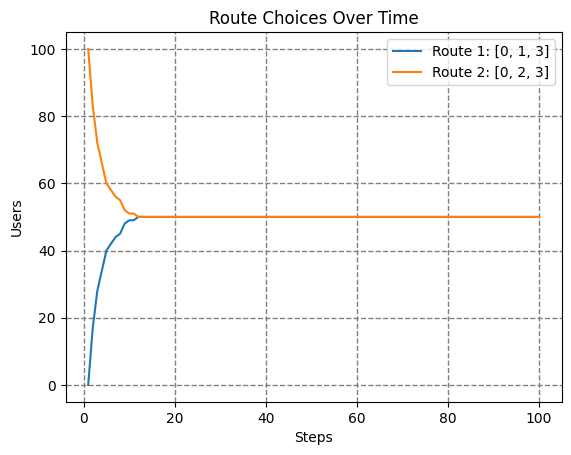

In [24]:
fig2, ax2 = plt.subplots()
for i, path in enumerate(model.routes):
    route_counts[i].plot(ax=ax2, label=f"Route {i+1}: {path}")
ax2.set_title("Route Choices Over Time")
ax2.set_xlabel("Steps")
ax2.set_ylabel("Users")
ax2.grid(axis='both', color='0.5', linestyle='--', linewidth=1)
ax2.legend()
plt.show()

Perhaps unsurprisingly, the agents quickly learn to distribute themeselves evenly between the two available routes.

## Average travel time

Let's plot the average travel time

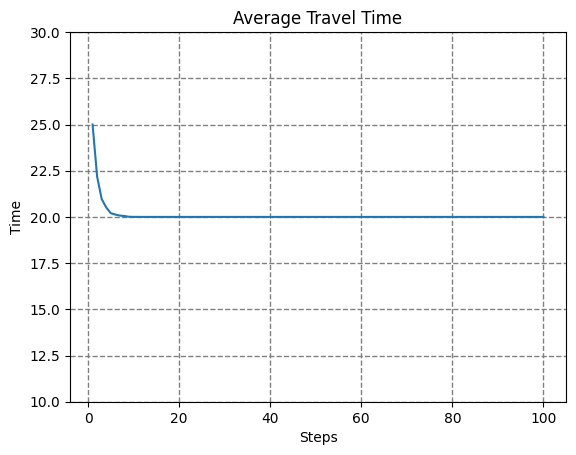

In [25]:
fig1, ax1 = plt.subplots()
ax1.plot(df_average_travel['Step'], df_average_travel['T'])
ax1.set_ylim(10.0, 30.0)
ax1.set_title("Average Travel Time")
ax1.set_xlabel("Steps")
ax1.set_ylabel("Time")
ax1.grid(axis='both', color='0.5', linestyle='--', linewidth=1)
plt.show()

## Average travel time
The system quickly settles to a Wardrop equilibrium of 20 minutes - consistent with the demand delay functions for the two routes.

## Aggregating data on the fly and querying the model

It is possible to use the ```model_reporters``` keyword to collect the summarised data at each step to avoid returning excessive amounts of data from large simulations and then doing complicated analyses of dataframes.

Here is an example:

In [26]:
model = CG.CGModel(num_agents=100, G=G, link_parameters=link_parameters, T=50.0)
model.datacollector = mesa.DataCollector(
    model_reporters={
        't1': lambda m: m.route_times[0],
        't2': lambda m: m.route_times[1],
    },
    agent_reporters={'travel_time': 'travel_time'}
)

for _ in range(100):
    model.step()

data_from_model = model.datacollector.get_model_vars_dataframe()
data_from_agents = model.datacollector.get_agent_vars_dataframe()

## Aggregating data on the fly and querying the model

In [27]:
print(data_from_agents.head())

              travel_time
Step AgentID             
1    1               25.0
     2               25.0
     3               25.0
     4               25.0
     5               25.0


In [28]:
print(data_from_model.head())

     t1    t2
0  15.0  25.0
1  16.7  23.3
2  17.7  22.3
3  18.2  21.8
4  18.8  21.2


## A (slightly) more complicated example

Let's add an additional road linking 1->2 with a cost of 5.0 -  a new bridge perhaps.

There is now an additional path in the network. Importantly some links are now shared between paths.

[(0, 1), (0, 2), (1, 2), (1, 3), (2, 3)]


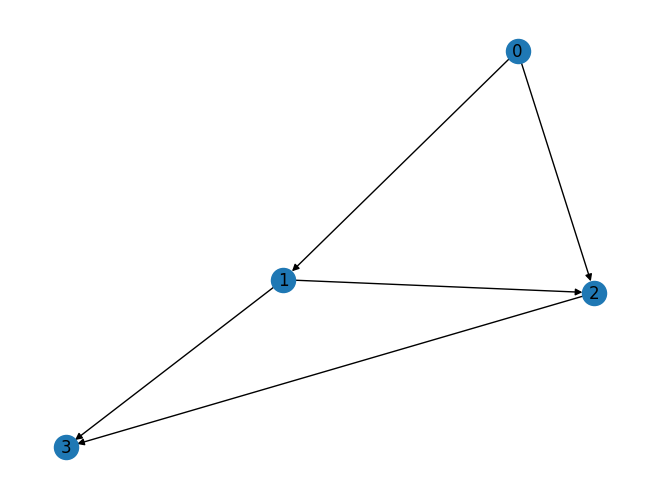

In [36]:
G2 = nx.DiGraph()
G2.add_edges_from([(0, 1), (0, 2), (1, 3), (2, 3), (1, 2)])

# define link parameters according to sorted edges
print(sorted(list(G2.edges())))
linkparams2 = [(0.1, 0.0),
               (0.0, 15.0),
               (0.0, 5.0), # (1->2)
               (0.0, 15.0),
               (0.1, 0.0)]

nx.draw(G2, with_labels = True)

## Run the model again

I have condensed all the above code into a module ```code/CG.py```:

In [37]:
data2, p3, p4 = CG.run_model(G=G2, link_parameters=linkparams2)
plt.close()
plt.close()

## Path flows including the bridge

Let's plot the number of users of each path

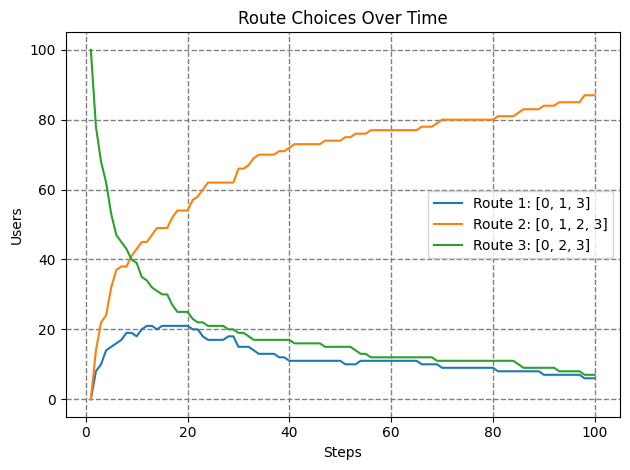

In [38]:
p4

The agents are now all switching to route 2 (including the bridge). It must be faster right?

## Average travel time

Wrong! When all agents switch to route 2, the average travel time now tends to 25 minutes.

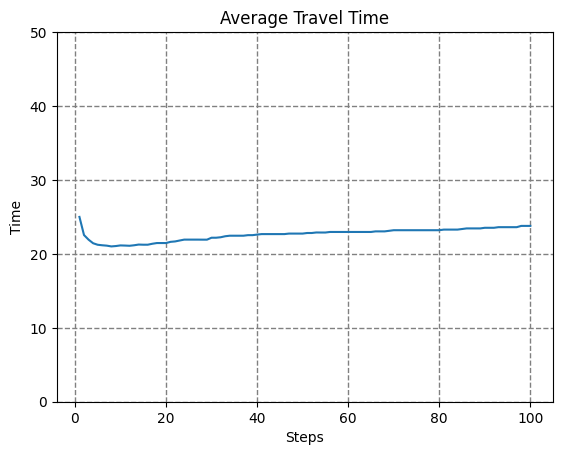

In [39]:
p3

The fact that adding *extra capacity* to transport networks can sometimes result in *increased* journey times is known as Braess' paradox.

## Mathematical analysis of the congestion game: decision variables and constraints
Let us now formulate the congestion game as an optimisation problem.

Decision variables: link and path flows:
$$X = (x_1, \ldots, x_{n_v}, h_1, \ldots h_{n_p})$$
These variables are not all independent. The following **constraints** must be satisfied:
* Flows are non-negative:
$$x_i\geq 0\ \ \ i=1\ldots n_v$$
$$h_j\geq 0\ \ \ j=1\ldots n_p$$

## Mathematical analysis of the congestion game: decision variables and constraints

* Path flows must match demand:
$$\sum_{i=1}^{n_p} h_i = 100$$
* Link flows must be consistent with path flows:
$$ \sum_{j=1}^{n_p} A_{i\,j}\,h_j = x_i  \ \ \ i=1\ldots n_v$$

## Mathematical analysis of the congestion game: optimand

What to optimise? Total travel time?

$$ F_{SO}(X) = \sum_{i=1}^{n_v} x_i\, \tau_i(x_i) $$.

We already know from our ABM that minimising the total travel time does not yield a Wardrop equilibrium. Minimising the total travel time yields a flow pattern which is called the "social optimum".

## Mathematical analysis of the congestion game: optimand

A flow pattern corresponding to a Wardrop equilibrium is obtained by minimising the Beckmann potential:

$$ F_{WE}(X) = \sum_{i=1}^{n_v} \int_0^{x_i}\, \tau_i(\chi)\ d\chi.$$

This is not obvious. The difference between the social optimum and the Wardrop equilibrium is called the "price of anarchy". 

## A closer look at the Beckmann potential

Why does the minimising the Beckmann potential produce a Wardrop equilibrium? Consider the discrete case:

$$ F_{WE}(X) = \sum_{i=1}^{n_v} \sum_{n=1}^{x_i} \tau_i(n)$$

Suppose the $x_i$ are such that $F_{WE}$ is a minimum (there is at least one such choice) that is *not* a Wardrop equilibrium.

Then there is at least one driver (on route A with edges $e_1, e_2,\ldots e_n$ say)  who can improve travel time by switching route (to route B with edges $e_1^\prime, e_2^\prime \ldots e_m^\prime$ say). 

## A closer look at the Beckmann potential

Upon switching, $F_{WE}$ decreases by $\sum_{j=1}^n \tau_{e_j}(x_{e_j})$ which is the travel time for route A and then increases by the new travel time for route B.

Since the the travel time of B is less than that of A, $F_{WE}$ decreases.

This contradicts the initial assumption of a minimum.

## Homework (or exam!) question
Consider the network above with demand-delay functions:
1. [1,2] : $\tau_1(x) = x/10 $ 
2. [1,3] : $\tau_2(x) = 15 $ 
3. [2,3] : $\tau_3(x) = 5 $ 
4. [2,4] : $\tau_4(x) = 15 $ 
5. [3,4] : $\tau_5(x) = x/10 $ 

Label the paths p1 = [1,2,4], p2 = [1,3,4], p3 = [1,2,3,4]
* Show that minimising $F_{SO}(X)$ gives $h_1=50$, $h_2 = 50$ and $h_3 = 0$ and a travel time of 20.0.
* Show that miminimising $F_{WE}(X)$ gives $h_1=0$, $h_2 = 0$ and $h_3 = 100$ and a travel time of 25.0.

This example is solvable by hand but larger networks quickly become intractable and we need to resort to numerical optimisation.

### Solution:

There are 8 decision variables: $\{x_1, x_2, x_3, x_4, x_5, h_1, h_2, h_3\}$.
The objective function to find a social optimum is:
$$F_\text{SO}(x_1, x_2, x_3, x_4, x_5) = \sum_{i=1}^5 x_i\,\tau_i(x_i) $$
With the link labels and parameters given above, the optimand is
$$F_\text{SO}(x_1, x_2, x_3, x_4, x_5) = \frac{x_1^2}{10} + 15 x_2 + 5 x_3 + 15 x_4 + \frac{x_5^2}{10},$$
and the constraints are
\begin{align}
100 & = h_1 + h_2 + h_3\\
x_1 & = h_1 + h_3 \\
x_2 & = h_2\\
x_3 & = h_3\\
x_4 & = h_1\\
x_5 & = h_2 + h_3.
\end{align}
Check that you understand where these come from.

### Solution:

We can eliminate the path flows in terms of the link flows: $h_1= x_4$, $h_2 = x_2$ and $h_3 = x_3$.
There remain 3 equation relating the 5 path flows:

\begin{align}
100 &= x_2 + x_3 + x_4 \\
x_1 &= x_4 + x_3\\
x_5 &= x_2 + x3.
\end{align}

Using these equations we can reduce the 5 degrees of freedom in the optimand to 2. We eliminate $x_2$, $x_4$ and $x_5$ and write everything in terms of $x_1$ and $x_3$:

\begin{align}
x_2 &= 100 - x_1\\
x_4 &= x_1 - x_3\\
x_5 &= 100 - x_1 + x_3.
\end{align}

The optimand is now a function of two variables:

$$F_\text{SO}(x_1, x_3) = \frac{x_1^2}{10} + 15\, (100-x_1) + 5\, x_3 + 15\, (x_1-x_3) + \frac{(100-x_1+x_3)^2}{10}.$$

### Solution:

We minimise by setting $\nabla\,F_\text{SO}(x_1, x_3) = 0$ but we should bear in mind that we still have the positivity constraints $x_1 \geq 0$, $x_3 \geq 0$. 

This gives:
\begin{align}
\frac{\partial F_\text{SO}}{\partial x_1} &= \frac{2}{5}\, x_1  - \frac{1}{5}\, x_3 - 20 &= 0 \\
\frac{\partial F_\text{SO}}{\partial x_3} &= -\frac{1}{5}\, x_1 + \frac{1}{5}\, x_3 + 10 &= 0.
\end{align}

Solving these gives:
\begin{align}
x_1 &= 50\\
x_3 &= 0.
\end{align}

Note how, in this case, the optimum turns out to be on the boundary of the feasible set.

The remaining link flows are then: $x_2 = 50$, $x_4 = 50$, $x_5 = 50$. The path flows are $h_1 = 50$, $h_2 = 50$ and $h_3 = 0$.

A similar calculation with a different optimand allows one to obtain the Wardrop equilibrium.

## Constrained optimisation

Computation of Wardrop equilbria and social optima in congestion games require optimisation of a nonlinear function of the link and path flows subject to a set of linear constraints. We must solve problems of the form:

$$ \min_{X} F(X)$$

subject to 

$$ A\,X = b$$
$$ X \geq 0$$



## Constrained optimisation
In MA934 we learned that solutions of constrained linear optimisation problems are always on the boundary of the feasible set. This is not true for constrained nonlinear optimisation problems.
![Constrained optimisation](images/Inequality_constraint_diagram.svg.png "Network 2")

[Onmyphd](https://commons.wikimedia.org/wiki/User:Onmyphd) [Inequality constraint diagram](https://commons.wikimedia.org/wiki/File:Inequality_constraint_diagram.svg) [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/legalcode)

## Reminder:  Frank - Wolfe algorithm

The Frank-Wolfe algorithm is an iterative algorithm for solving nonlinear optimisation problems with constraints.The basic idea is to linearise:
$$ F(X_k+X) = F(X_k) + (X-X_k) \cdot \nabla\, F(X_k) + \ldots$$
At each step of the iteration we linearise the objective function about the current point and the obtain the next point by solving the resulting contstrained linear optimisation problem - e.g. using the Dantzig algorithm.
* initial guess: $k=0$, $X = X_0$
* Solve the linearised problem
$$s_k = \text{arg} \min_{s} s\cdot \nabla\,F(s)$$
subject to 
$$ A\,s = b$$
$$ s \geq 0$$
* Calculate step size: $\gamma_k = \frac{2}{k+2}$ 
* Update our solution: $X_{k+1} = X_k + \gamma_k\,(s_k - X_k)$, $\ \ \ k=k+1$
